- Filename: Eval-Speed_Plot-Fig3Fig4FigS1.ipynb
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: June 2023
- Last updated: Aug 12th 2024
- Description:
Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., used to produce Figures 3, 4, and S1

# Comparing gridded surface speed from ocean-only (uncoupled) and ocean-wave (coupled) model simulations for the Mediterranean Sea

# 1. General Settings

### 1.1 Load modules and check versions

In [1]:
from glob import glob

import numpy as np
import xarray as xr

import datetime

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm

import utils
from utils import ColorSettings as cparams

In [2]:
utils.print_imported_package_versions(globals())

xarray==2022.12.0
matplotlib==3.6.2
numpy==1.24.1


### 1.2 Set input and output paths

In [3]:
gridpath = '../data-orig/'

maskpath = '../data-proc/domain/'

datapath = '../data-proc/eul/speed/'

outpath_figs = '../figs/'

### 1.3 Define custom parameters

In [4]:
# Define whether Mediterranean Sea mask (excluding Atlantic grid points) should be created and saved
# This is necessary for the calculation of the Mediterranean Sea mean
# Only has to be performed once
key_create_Mask_MedSea = False

In [5]:
col_blue = cparams.blue
col_cyan = cparams.cyan
col_green = cparams.green
col_yellow = cparams.yellow
col_red = cparams.red
col_purple = cparams.purple
col_grey = cparams.grey

alpha = 0.5
col_blue_alpha = (cparams.blue[0], cparams.blue[1], cparams.blue[2],
                  alpha)
col_yellow_alpha = (cparams.yellow[0], cparams.yellow[1], cparams.yellow[2],
                    alpha)
col_grey_alpha = (cparams.grey[0], cparams.grey[1], cparams.grey[2],
                  alpha)
col_black_alpha = (0, 0, 0, 0.65)

# not in original color scale
col_darkgrey = (50/255, 50/255, 50/255)

## 2. Loading Data

In [6]:
grid = xr.open_dataset(
    gridpath + 'mesh_mask.nc', drop_variables=('x', 'y'))

regionmask = xr.open_dataset(
    maskpath + 'MEDregions.nc').rename({'jm': 'y', 'im': 'x'})

In [7]:
speed_tave_ds = xr.open_mfdataset(sorted(glob(datapath
                                              + 'Speed-tave-fulldepth-*.nc')),
                                              combine='nested', concat_dim='z')

speed_tsave_ds = xr.open_mfdataset(sorted(glob(datapath
                                               + 'Speed-tseasonave-fulldepth-*.nc')),
                                               combine='nested', concat_dim='z')

In [8]:
speed_rave_ds = xr.open_dataset(datapath + 'Speed-rave-weighted-z001.nc')

# 3. Additional Analysis

### 3.1 Mask for Mediterranean Sea only (exlcluding Atlantic grid points)

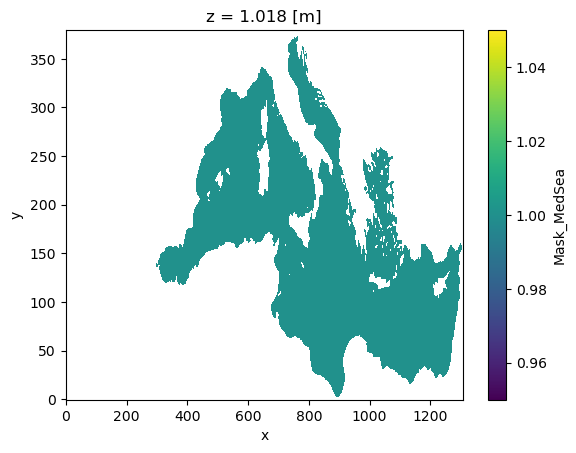

In [9]:
if key_create_Mask_MedSea == True:
    base = speed_tave_ds.EncSc.isel(z=0) * 0
    test1 = base.where(base.nav_lon > -1, 1)
    test2 = base.where(base.nav_lat < 43, 1)
    test3 = test1 + test2
    test4 = test3.where(base.nav_lon > -5.7, 2)
    Mask_MedSea = ((test4.where(test4 != 2))*0+1).rename('Mask_MedSea')
    Mask_MedSea.to_netcdf(maskpath + 'Mask_MedSea.nc')
else:
    Mask_MedSea_ds = xr.open_dataset(maskpath + 'Mask_MedSea.nc')
    Mask_MedSea = Mask_MedSea_ds.Mask_MedSea

Mask_MedSea.plot()
    

### 3.2 Spatially averaged temporal evolution of the impact of waves on speed

In [10]:
speed_rave_imp_al = speed_rave_ds.EcSc - speed_rave_ds.Enc
speed_rave_imp_sd = speed_rave_ds.ScProjEcSc
speed_rave_imp_ec = (speed_rave_ds.EcSc
                      - speed_rave_ds.ScProjEcSc - speed_rave_ds.Enc)
# alterantive formulation for speed_rave_imp_ec:
# speed_rave_imp_ec = speed_rave_ds.EcProjEcSc - speed_rave_ds.Enc
# analytically identical, but very minor differences O(10^-7) due to numerical errors

### 3.3 Changes in annual/seasonal mean vertical profiles of speed

The following procedure is adopted:
1) Calculate difference in annual/seasonal mean speed per grid point
3) Perform regional averaging considering weights according to grid cell size

In [11]:
speed_tsave_imp_al = speed_tsave_ds.EcSc - speed_tsave_ds.Enc
speed_tsave_imp_sd = speed_tsave_ds.ScProjEcSc
speed_tsave_imp_ec = speed_tsave_ds.EcSc - speed_tsave_ds.ScProjEcSc - speed_tsave_ds.Enc

speed_tave_imp_al = speed_tave_ds.EcSc - speed_tave_ds.Enc
speed_tave_imp_sd = speed_tave_ds.ScProjEcSc
speed_tave_imp_ec = speed_tave_ds.EcSc - speed_tave_ds.ScProjEcSc - speed_tave_ds.Enc

In [12]:
# For consistency, we here calculate the weighted spatial average
# however, the weightening has a hardly noticable, i.e. non-significant effect on the results
# as all grid cells have very similar areas
def calc_weighted2Dave(tsave):
    zweight_tmp = grid.umask.rename({'nav_lev':'z'}).where(Mask_MedSea == 1)
    zweight_tmp2 = zweight_tmp.squeeze() * grid.e1u.squeeze() * grid.e2u.squeeze()
    zweight = zweight_tmp2/zweight_tmp2.sum(dim=('x', 'y'), skipna=True)
    xyave = (tsave*zweight).sum(dim=('x', 'y'), skipna=True)
    return xyave

speed_tsave_imp_al_xyave = calc_weighted2Dave(speed_tsave_imp_al)
speed_tsave_imp_sd_xyave = calc_weighted2Dave(speed_tsave_imp_sd)
speed_tsave_imp_ec_xyave = calc_weighted2Dave(speed_tsave_imp_ec)

### 3.4 Calculate vertically integrated impact of waves

In [13]:
def calc_weightedzave(xyave, zslice):
    zweight_tmp = grid.umask * grid.e1u * grid.e2u * grid.e3u_0
    zweight_tmp2 = zweight_tmp.rename({'nav_lev':'z'}).where(Mask_MedSea == 1).squeeze() 
    zweight = zweight_tmp2.isel(z=zslice)/zweight_tmp2.isel(z=zslice).sum(dim=('x', 'y', 'z'), skipna=True)

    zave = (xyave.isel(z=zslice) * zweight).sum(dim=('x', 'y', 'z'), skipna=True)

    return zave.values

In [14]:
maxz_values = [7, 25, 140]

for maxz in maxz_values:

    print('Weighted vertical averages of total current speed (zlevels 0 to ' + str(maxz) + ')',
          'i.e., for the upper ' + str(grid.nav_lev.isel(nav_lev=maxz).values) + ' meters')

    speed_tsave_imp_ec_xyave_DJF_zmean = calc_weightedzave(
        speed_tsave_imp_ec_xyave.sel(season='DJF'), slice(0, maxz, 1))
    speed_tsave_imp_ec_xyave_JJA_zmean = calc_weightedzave(
        speed_tsave_imp_ec_xyave.sel(season='JJA'), slice(0, maxz, 1))
    speed_tsave_imp_al_xyave_DJF_zmean = calc_weightedzave(
        speed_tsave_imp_al_xyave.sel(season='DJF'), slice(0, maxz, 1))
    speed_tsave_imp_al_xyave_JJA_zmean = calc_weightedzave(
        speed_tsave_imp_al_xyave.sel(season='JJA'), slice(0, maxz, 1))
    speed_tsave_imp_sd_xyave_DJF_zmean = calc_weightedzave(
        speed_tsave_imp_sd_xyave.sel(season='DJF'), slice(0, maxz, 1))
    speed_tsave_imp_sd_xyave_JJA_zmean = calc_weightedzave(
        speed_tsave_imp_sd_xyave.sel(season='JJA'), slice(0, maxz, 1))

    print('Total impact')
    print('winter: ' + str(speed_tsave_imp_al_xyave_DJF_zmean))
    print('summer: ' + str(speed_tsave_imp_al_xyave_JJA_zmean))

    print('Eulerian current contribution')
    print('winter: ' + str(speed_tsave_imp_ec_xyave_DJF_zmean))
    print('summer: ' + str(speed_tsave_imp_ec_xyave_JJA_zmean))

    print('Stokes drift contribution')
    print('winter: ' + str(speed_tsave_imp_sd_xyave_DJF_zmean))
    print('summer: ' + str(speed_tsave_imp_sd_xyave_JJA_zmean))

Weighted vertical averages of total current speed (zlevels 0 to 7) i.e., for the upper 19.39821 meters
Total impact
winter: 0.0012540968537429235
summer: -0.0007638618567692593
Eulerian current contribution
winter: -0.001345196806743173
summer: -0.00138493460051299
Stokes drift contribution
winter: 0.002599293667916255
summer: 0.0006210727474939548
Weighted vertical averages of total current speed (zlevels 0 to 25) i.e., for the upper 112.250206 meters
Total impact
winter: 0.00035981297992346826
summer: -0.00045770822026607684
Eulerian current contribution
winter: -0.00010621752838881393
summer: -0.0005663983720053775
Stokes drift contribution
winter: 0.0004660305069041673
summer: 0.0001086901604840047
Weighted vertical averages of total current speed (zlevels 0 to 140) i.e., for the upper 5754.044 meters
Total impact
winter: -0.0003518272853043502
summer: -0.000219471439243433
Eulerian current contribution
winter: -0.0003745839309707377
summer: -0.00025249602277368263
Stokes drift con

## 4. Visualization

### 4.1 Figure 3: Impact of surface waves on simulated horizontal Lagrangian speed averaged over whole Mediterranean Sea
Caption: (a) Temporal variability of the impact of waves on surface speed: daily (thin) and monthly filtered (thick, 30-day running mean) timeseries of the total wave impact (solid line) and the corresponding Stokes drift (dashed line) and Eulerian current (dotted line) contributions. (b) Full timeseries of the simulated Lagrangian surface speed for the coupled and non-coupled simulations. (c) Vertical profile of the impact of waves for winter (DJF, blue) and summer (JJA, yellow), note that the vertical axis is split and that the Stokes drift component is zero for all depths displayed in the lower part (i.e., the curves for the total impact and the Eulerian current contribution lay on top of each other).

In [22]:
# Define plotting parameters and custom plotting functions

fs = 'xx-small'
lw = 0.5
lw2 = 1.0
lw3 = 1.2
lw_box = 0.8
col = col_darkgrey
col2 = col_grey
ymin = -0.035
ymax = 0.045
ymin2 = 0.105
ymax2 = 0.195


def season_shading(ax, ymin, ymax):
    ax.fill_between([datetime.date(2019, 1, 1), datetime.date(2019, 2, 28)],
                    [ymin, ymin], [ymax, ymax],
                    color=col_blue, alpha=0.2)
    ax.fill_between([datetime.date(2019, 12, 1), datetime.date(2020, 2, 28)],
                    [ymin, ymin], [ymax, ymax],
                    color=col_blue, alpha=0.2)
    ax.fill_between([datetime.date(2020, 12, 1), datetime.date(2020, 12, 31)],
                    [ymin, ymin], [ymax, ymax],
                    color=col_blue, alpha=0.2)
    ax.fill_between([datetime.date(2019, 6, 1), datetime.date(2019, 8, 31)],
                    [ymin, ymin], [ymax, ymax],
                    color=col_yellow, alpha=0.2)
    ax.fill_between([datetime.date(2020, 6, 1), datetime.date(2020, 8, 31)],
                    [ymin, ymin], [ymax, ymax],
                    color=col_yellow, alpha=0.2)


def plot_depthprofiles_impact(zmin, zmax, linew):

    # summer profiles
    plt.plot(speed_tsave_imp_ec_xyave.sel(season='DJF').isel(z=slice(zmin, zmax+1, 1))*0,
             -speed_tsave_imp_ec_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color='k', linewidth=linew)
    plt.plot(speed_tsave_imp_al_xyave.sel(season='JJA').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_al_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_yellow, linewidth=linew,
             label='total JJA')
    plt.plot(speed_tsave_imp_sd_xyave.sel(season='JJA').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_sd_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_yellow, linewidth=linew, linestyle='dashed',
             label='Stokes JJA')
    plt.plot(speed_tsave_imp_ec_xyave.sel(season='JJA').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_ec_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_yellow, linewidth=linew, linestyle='dotted',
             label='Euler JJA')
    # winter profiles
    plt.plot(speed_tsave_imp_al_xyave.sel(season='DJF').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_al_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_blue, linewidth=linew,
             label='total DJF')
    plt.plot(speed_tsave_imp_sd_xyave.sel(season='DJF').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_sd_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_blue, linewidth=linew, linestyle='dashed',
             label='Stokes DJF')
    plt.plot(speed_tsave_imp_ec_xyave.sel(season='DJF').isel(z=slice(zmin, zmax+1, 1)),
             -speed_tsave_imp_ec_xyave.z.isel(z=slice(zmin, zmax+1, 1)),
             color=col_blue, linewidth=linew, linestyle='dotted',
             label='Euler DJF')

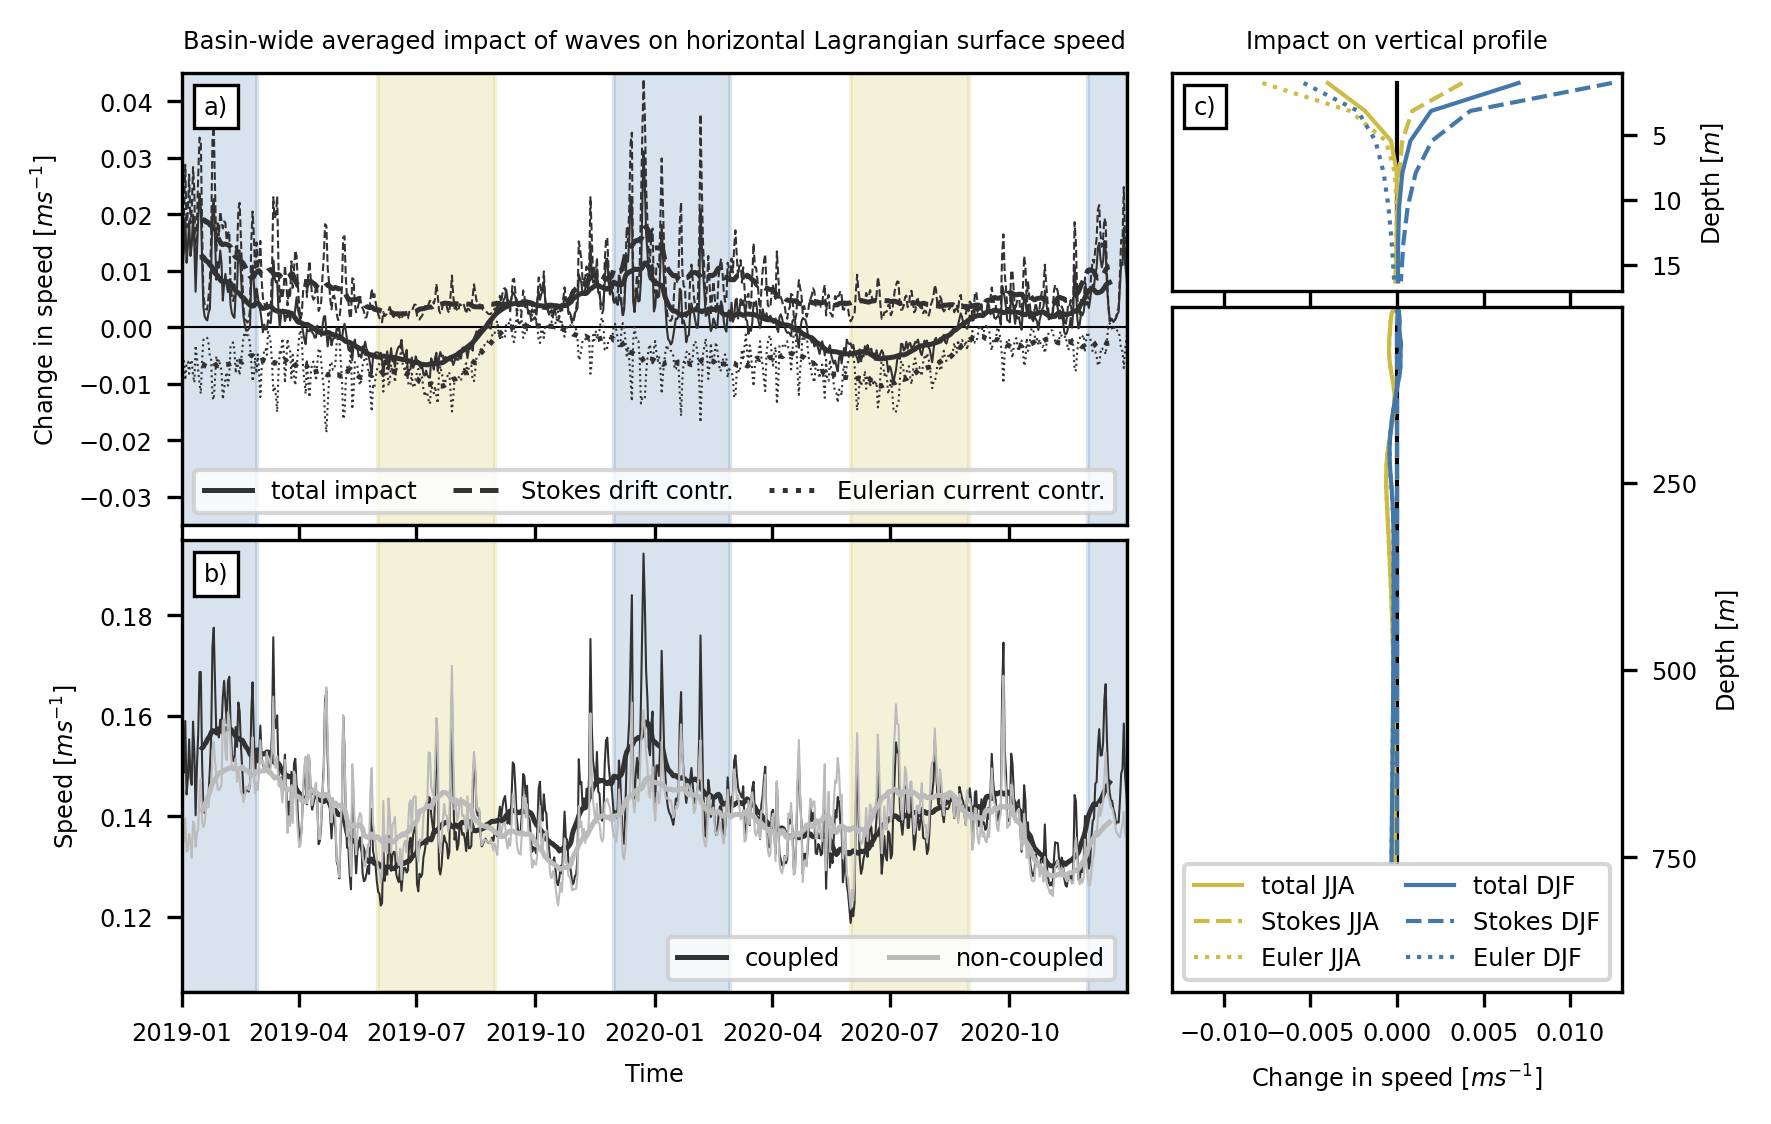

In [24]:
# Do the plotting

fig = plt.figure(figsize=(6, 6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3,
                      left=0.1, right=0.9,
                      wspace=0.1, hspace=0.07)

# Subplot (a)
ax = fig.add_subplot(gs[0:2, 0:2])
# Season background shading and horizontal zero line
season_shading(ax, ymin, ymax)
ax.plot(speed_rave_imp_al.time_counter, speed_rave_imp_al*0,
        color='k', linewidth=lw)
# Total impact
ax.plot(speed_rave_imp_al.time_counter, speed_rave_imp_al,
        color=col, linewidth=lw)
ax.plot(speed_rave_imp_al.time_counter,
        speed_rave_imp_al.rolling(time_counter=30, center=True).mean(),
        color=col, linewidth=lw3,
        label='total impact')
# Stokes drift contribution
ax.plot(speed_rave_imp_sd.time_counter, speed_rave_imp_sd,
        color=col, linestyle='dashed', linewidth=lw)
ax.plot(speed_rave_imp_sd.time_counter,
        speed_rave_imp_sd.rolling(time_counter=30, center=True).mean(),
        color=col, linestyle='dashed', linewidth=lw3,
        label='Stokes drift contr.')
# Eulerian current contribution
ax.plot(speed_rave_imp_ec.time_counter, speed_rave_imp_ec,
        color=col, linestyle='dotted', linewidth=lw)
ax.plot(speed_rave_imp_ec.time_counter,
        speed_rave_imp_ec.rolling(time_counter=30, center=True).mean(),
        color=col, linestyle='dotted', linewidth=lw3,
        label='Eulerian current contr.')
# Legend
ax.legend(loc='lower center', mode='expand',
          ncol=3, fancybox=True, fontsize=fs)
# Labels and axis settings
ax.tick_params(labelsize=fs)
ax.set_xticklabels([])
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 12, 31)])
ax.set_ylim([ymin, ymax])
ax.set_ylabel('Change in speed [$ms^{-1}$]', fontsize=fs)
ax.set_title('Basin-wide averaged impact of waves on horizontal Lagrangian surface speed',
             fontsize=fs, horizontalalignment='center')
at = AnchoredText('a)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)


# Subplot (b)
ax = fig.add_subplot(gs[2:4, 0:2])
# Season background shading
season_shading(ax, ymin2, ymax2)
# Coupled simulation
ax.plot(speed_rave_ds.time_counter, speed_rave_ds.EcSc,
        color=col, linewidth=lw)
ax.plot(speed_rave_ds.time_counter,
        speed_rave_ds.EcSc.rolling(time_counter=30, center=True).mean(),
        color=col, linewidth=lw3,
        label='coupled')
# Non-coupled simulation
ax.plot(speed_rave_ds.time_counter, speed_rave_ds.Enc,
        color=col2, linewidth=lw)
ax.plot(speed_rave_ds.time_counter,
        speed_rave_ds.Enc.rolling(time_counter=30, center=True).mean(),
        color=col2, linewidth=lw3,
        label='non-coupled')
# Legend
ax.legend(loc='lower right',
          ncol=2, fancybox=True, fontsize=fs)
# Labels and axis settings
ax.tick_params(labelsize=fs)
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 12, 31)])
ax.set_ylim([ymin2, ymax2])
ax.set_ylabel('Speed [$ms^{-1}$]', fontsize=fs)
ax.set_xlabel('Time', fontsize=fs)
at = AnchoredText('b)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)


# Subplot (c)
ax = fig.add_subplot(gs[0:1, 2:3])
# Plot depth profiles upper 15 m
plot_depthprofiles_impact(0, 6, lw2)
# Labels and axis settings
ax.set_xlim([-0.013, 0.013])
ax.tick_params(labelsize=fs)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_yticks([-15, -10, -5])
ax.set_yticklabels(['15', '10', '5'])
ax.set_ylabel('Depth [$m$]', fontsize=fs)
ax.set_title('Impact on vertical profile',
             fontsize=fs, horizontalalignment='center')
at = AnchoredText('c)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs[1:4, 2:3])
# Plot depth profiles below 15 m
plot_depthprofiles_impact(7, 65, lw2)
# Legend
ax.legend(loc='lower right', mode='expand', markerscale=0.5,
          ncol=2, fancybox=True, fontsize=fs)
# Labels and axis settings
ax.set_xlim([-0.013, 0.013])
ax.tick_params(labelsize=fs)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel('Depth [$m$]', fontsize=fs)
ax.set_ylim([-930, -15])
ax.set_yticks([-750, -500, -250])
ax.set_yticklabels(['750', '500', '250'])
ax.set_xlabel('Change in speed [$m s^{-1}$]', fontsize=fs)


# Save the figure
fig.savefig('../figs/png/fig03.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig03.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)

### 4.2 Figure 4: Regionally averaged impact of the representation of surface waves on simulated mean Lagrangian surface on annual, summer, and winter mean speed

Caption:(a)-(c) Total impact of the representation of waves, (d)-(f) Stokes drift ontribution, (g)-(h) Eulerian current contribuition. Averages were calculated over the following regions: (1) Alboran Sea, (2) South West Med 1 (western part), (3) North West Med, (4) South West Med 2 (eastern part), (5) Tyrrhenian Sea 2 (southern part), (6) Tyrrhenian Sea (northern part), (7) Ionian Sea 1 (western part), (8) Ionian Sea 2 (south-eastern part), (9) Ionian Sea 3 (north-eastern part), (10) Adriatic Sea 2 (southern part), (11) Adriatic Sea 1 (northern part), (12) Levantine Sea 1 (western part), (13) Aegean Sea, (14) Levantine Sea 2 (central-northern part), (15) Levantine Sea 3 (central southern part), (16) Levantine Sea 4 (eastern part).

In [17]:
# Define plotting parameters and custom functions

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0, 10, 20, 30]
yticks = [35, 40, 45]
xticklabs = ['0° E', '10° E', '20° E', '30° E']
yticklabs = ['35° N', '40° N', '45° N']

fs = 'xx-small'

nctic = 5
zlev = 0

colm = cm.RdBu_r
levs = np.arange(-0.02, 0.02, 0.002)
norm = colors.BoundaryNorm(boundaries=levs+0.002/2, ncolors=colm.N)
ncticks = [-0.016, -0.008, 0, 0.008, 0.016]


def _calc_reg_ave(var):
    var_rave = var.copy()*0
    var_rave_slim_list = []
    for i in range(17):
        reg = float(i + 1)
        regmask = regionmask.regs.assign_coords(
            {'nav_lon': var.nav_lon, 'nav_lat': var.nav_lat})
        tmp = var.where(regionmask.regs == reg).where(
            Mask_MedSea == 1).mean(dim=['x', 'y'], skipna=True)
        tmp2 = (var.where(regionmask.regs == reg).where(
            Mask_MedSea == 1)*0 + tmp).fillna(0)
        var_rave = var_rave + tmp2
        var_rave_slim_list.append(tmp)
    var_rave_slim = xr.concat(var_rave_slim_list, dim='regs').assign_coords(
        {'regs': np.arange(17)+1})
    return var_rave, var_rave_slim


def _add_regnumbers():
    ax.text(-3.2, 35.8, "1", fontsize=fs)
    ax.text(2.2, 37.7, "2", fontsize=fs)
    ax.text(5, 41, "3", fontsize=fs)
    ax.text(6.8, 38, "4", fontsize=fs)
    ax.text(12, 39, "5", fontsize=fs)
    ax.text(10, 41.5, "6", fontsize=fs)
    ax.text(12, 34.5, "7", fontsize=fs)
    ax.text(18, 33.5, "8", fontsize=fs)
    ax.text(18, 38, "9", fontsize=fs)
    ax.text(17, 41, "10", fontsize=fs)
    ax.text(14.3, 43, "11", fontsize=fs)
    ax.text(23, 33.5, "12", fontsize=fs)
    ax.text(24, 36, "13", fontsize=fs)
    ax.text(29, 34, "14", fontsize=fs)
    ax.text(28.5, 32, "15", fontsize=fs)
    ax.text(33, 33, "16", fontsize=fs)


def build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                     xticklabel=True, yticklabel=True):
    var_tmp = (var1 - var2)
    var, var_slim = _calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    utils.plot_bathy(grid)
    ax.set_xlim([lonmin_plot, lonmax_plot])
    ax.set_ylim([latmin_plot, latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel == False:
        ax.set_xticklabels([])
    if yticklabel == False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map, var_slim


def build_subplot_pcolorregspeed(var1, colm, norm,
                                 xticklabel=True, yticklabel=True):
    var_tmp = var1
    var, var_slim = _calc_reg_ave(var_tmp)
    map = plt.pcolor(var.nav_lon, var.nav_lat,
                     var,
                     cmap=colm, norm=norm,
                     shading='nearest')
    utils.plot_bathy(grid)
    ax.set_xlim([lonmin_plot, lonmax_plot])
    ax.set_ylim([latmin_plot, latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(yticklabs)
    if xticklabel == False:
        ax.set_xticklabels([])
    if yticklabel == False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map, var_slim

/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_4183/4287073711.py:64: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var.nav_lon, var.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_4183/4287073711.py:64: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(var.nav_lon, var.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_4183/4287073711.py:64: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges

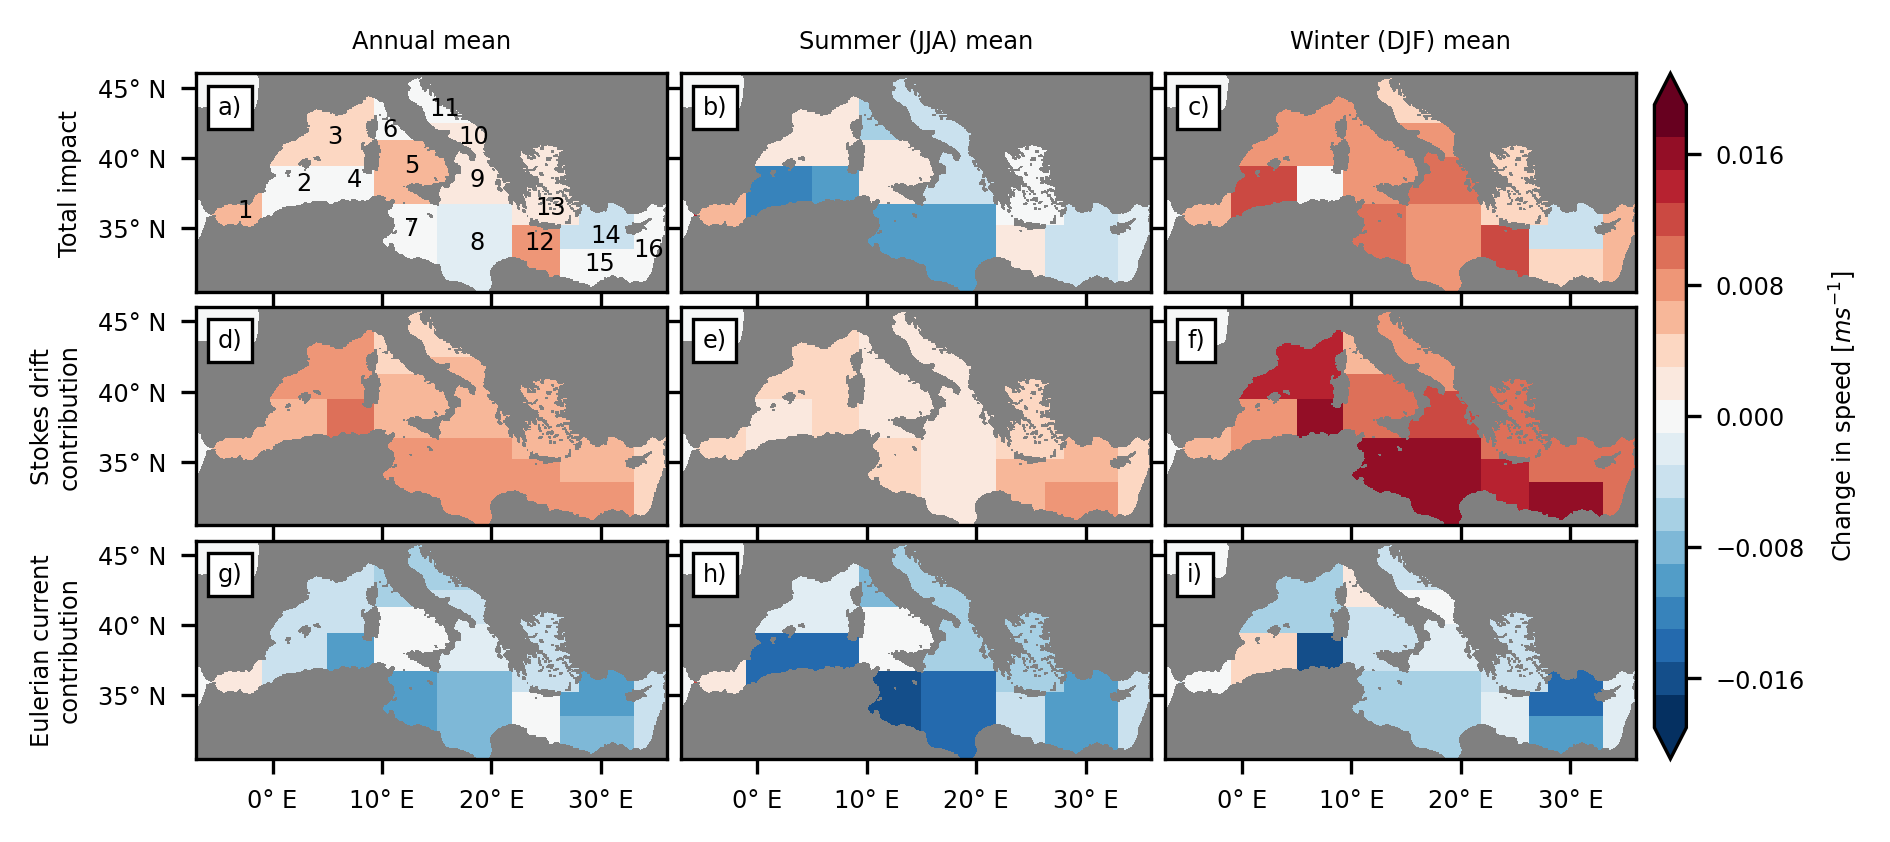

In [18]:
# Do the  plotting

fig = plt.figure(figsize=(6, 6), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=6, ncols=3,
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5,
                       left=0.1, right=0.9,
                       wspace=0.05, hspace=0.15)
gscbar = fig.add_gridspec(nrows=6, ncols=100,
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.07)

# Total impact (subplots a-c)
# annual mean
ax = fig.add_subplot(gs[3, 0])
var1 = speed_tave_ds.isel(z=zlev).EcSc
var2 = speed_tave_ds.isel(z=zlev).Enc
map, Tot_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                                xticklabel=False)
ax.set_ylabel('Total impact', fontsize=fs)
ax.set_title('Annual mean', fontsize=fs)
_add_regnumbers()
at = AnchoredText('a)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# summer mean
ax = fig.add_subplot(gs[3, 1])
var1 = speed_tsave_ds.sel(season='JJA').isel(z=zlev).EcSc
var2 = speed_tsave_ds.sel(season='JJA').isel(z=zlev).Enc
map, Tot_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                                yticklabel=False, xticklabel=False)
ax.set_title('Summer (JJA) mean', fontsize=fs)
at = AnchoredText('b)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# winter mean
ax = fig.add_subplot(gs[3, 2])
var1 = speed_tsave_ds.sel(season='DJF').isel(z=zlev).EcSc
var2 = speed_tsave_ds.sel(season='DJF').isel(z=zlev).Enc
map, Tot_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                                yticklabel=False, xticklabel=False)
ax.set_title('Winter (DJF) mean', fontsize=fs)
at = AnchoredText('c)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

# Stokes drift impact (subplots (d-f))
# annual mean
ax = fig.add_subplot(gs[4, 0])
var1 = speed_tave_ds.isel(z=zlev).ScProjEcSc
map, Sto_ann = build_subplot_pcolorregspeed(var1, colm, norm,
                                            xticklabel=False)
ax.set_ylabel('Stokes drift\ncontribution', fontsize=fs)
at = AnchoredText('d)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# summer mean
ax = fig.add_subplot(gs[4, 1])
var1 = speed_tsave_ds.sel(season='JJA').isel(z=zlev).ScProjEcSc
map, Sto_jja = build_subplot_pcolorregspeed(var1, colm, norm,
                                            yticklabel=False, xticklabel=False)
at = AnchoredText('e)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# winter mean
ax = fig.add_subplot(gs[4, 2])
var1 = speed_tsave_ds.sel(season='DJF').isel(z=zlev).ScProjEcSc
map, Sto_djf = build_subplot_pcolorregspeed(var1, colm, norm,
                                            yticklabel=False, xticklabel=False)
ax.text(55, latmin_plot+(latmax_plot-latmin_plot)/2, 'Change in speed [$m s^{-1}$]',
        horizontalalignment='center', verticalalignment='center',
        fontsize=fs, rotation=90)
at = AnchoredText('f)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

# Eulerian impact (subplots (g-i))
# annual mean
ax = fig.add_subplot(gs[5, 0])
var1 = speed_tave_ds.isel(z=zlev).EcProjEcSc
var2 = speed_tave_ds.isel(z=zlev).Enc
map, Eul_ann = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm)
cbaxes = fig.add_subplot(gscbar[3:6, 90:92])
cbar = plt.colorbar(map, cax=cbaxes, ticks=ncticks,
                    orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=fs)
cbar.minorticks_off()
ax.set_ylabel('Eulerian current\ncontribution', fontsize=fs)
at = AnchoredText('g)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# summer mean
ax = fig.add_subplot(gs[5, 1])
var1 = speed_tsave_ds.sel(season='JJA').isel(z=zlev).EcProjEcSc
var2 = speed_tsave_ds.sel(season='JJA').isel(z=zlev).Enc
map, Eul_jja = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                                yticklabel=False)
at = AnchoredText('h)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)
# winter mean
ax = fig.add_subplot(gs[5, 2])
var1 = speed_tsave_ds.sel(season='DJF').isel(z=zlev).EcProjEcSc
var2 = speed_tsave_ds.sel(season='DJF').isel(z=zlev).Enc
map, Eul_djf = build_subplot_pcolorregspeeddiff(var1, var2, colm, norm,
                                                yticklabel=False)
at = AnchoredText('i)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)


# Save the figure
fig.savefig('../figs/png/fig04.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig04.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)

### 4.3 Figure S1: Impact of the representation of surface waves on simulated mean Lagrangian surface speed in predefined regions of the Mediterranean Sea.

In [19]:
# Define plotting parameters and custom functions

col_jja = col_yellow_alpha
col_jja2 = col_yellow
col_djf = col_blue_alpha
col_djf2 = col_blue
sym_eul = 's'
sym_sto = '^'
msize = 2
bwidth = 0.15

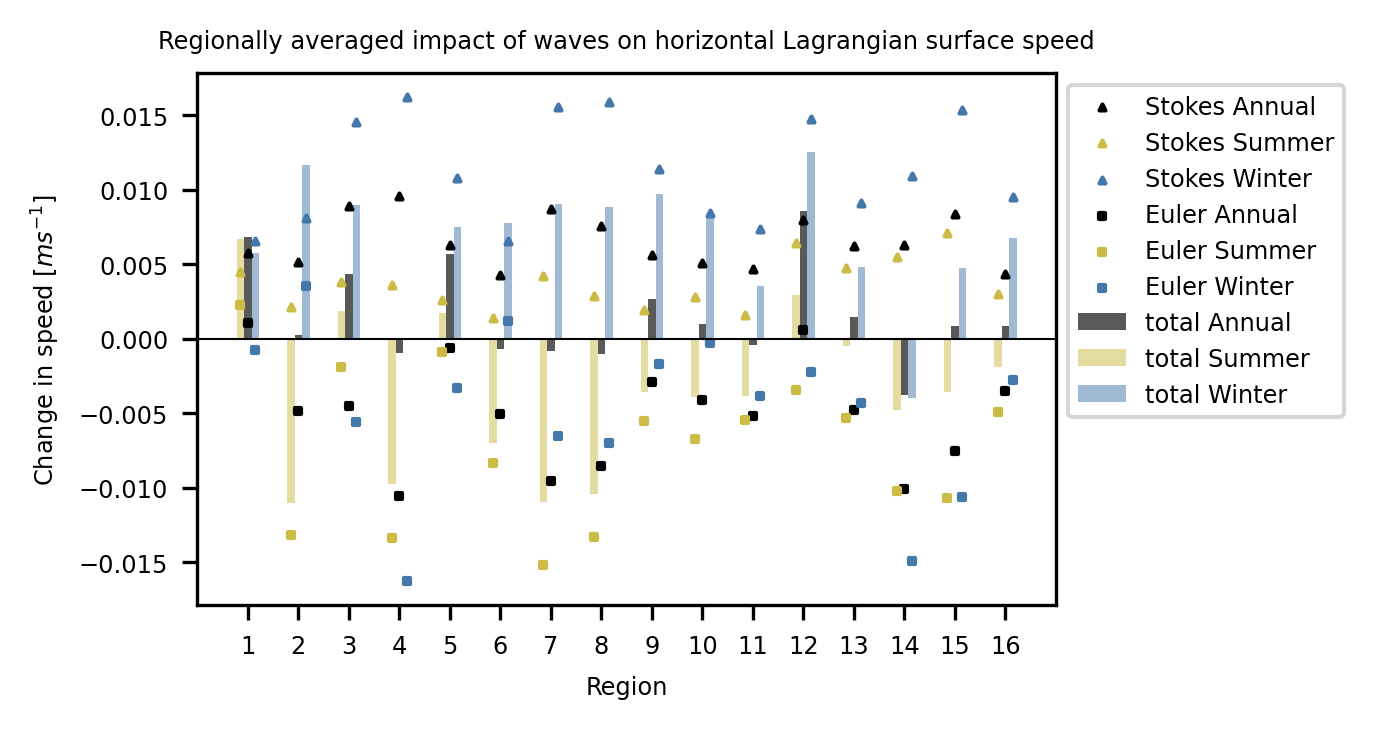

In [20]:
# Do the plotting

fig = plt.figure(figsize=(6, 6), dpi=300, constrained_layout=False)
gs2 = fig.add_gridspec(nrows=5, ncols=5,
                       left=0.1, right=0.9,
                       wspace=0.05, hspace=0.15)

# Overall region statistics
ax = fig.add_subplot(gs2[0:2, 1:4])
ax.bar(Tot_ann.isel(regs=np.arange(0, 16, 1)).regs,
       Tot_ann.isel(regs=np.arange(0, 16, 1)),
       color=col_black_alpha, width=bwidth, label='total Annual')
ax.bar(Tot_jja.isel(regs=np.arange(0, 16, 1)).regs-bwidth,
       Tot_jja.isel(regs=np.arange(0, 16, 1)),
       color=col_jja, width=bwidth, label='total Summer')
ax.bar(Tot_djf.isel(regs=np.arange(0, 16, 1)).regs+bwidth,
       Tot_djf.isel(regs=np.arange(0, 16, 1)),
       color=col_djf, width=bwidth, label='total Winter')
ax.scatter(Sto_ann.isel(regs=np.arange(0, 16, 1)).regs,
           Sto_ann.isel(regs=np.arange(0, 16, 1)),
           color='k', marker=sym_sto, s=msize, label='Stokes Annual')
ax.scatter(Sto_jja.isel(regs=np.arange(0, 16, 1)).regs-bwidth,
           Sto_jja.isel(regs=np.arange(0, 16, 1)),
           color=col_jja2, marker=sym_sto, s=msize, label='Stokes Summer')
ax.scatter(Sto_djf.isel(regs=np.arange(0, 16, 1)).regs+bwidth,
           Sto_djf.isel(regs=np.arange(0, 16, 1)),
           color=col_djf2, marker=sym_sto, s=msize, label='Stokes Winter')
ax.scatter(Eul_ann.isel(regs=np.arange(0, 16, 1)).regs,
           Eul_ann.isel(regs=np.arange(0, 16, 1)),
           color='k', marker=sym_eul, s=msize, label='Euler Annual')
ax.scatter(Eul_jja.isel(regs=np.arange(0, 16, 1)).regs-bwidth,
           Eul_jja.isel(regs=np.arange(0, 16, 1)),
           color=col_jja2, marker=sym_eul, s=msize, label='Euler Summer')
ax.scatter(Eul_djf.isel(regs=np.arange(0, 16, 1)).regs+bwidth,
           Eul_djf.isel(regs=np.arange(0, 16, 1)),
           color=col_djf2, marker=sym_eul, s=msize, label='Euler Winter')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
ax.set_xlim([0, 17])
ax.plot([0, 17], [0, 0], color='k', linewidth=0.5)
ax.tick_params(axis='both', labelsize=fs)
ax.set_xticks(np.arange(1, 17))
ax.set_xlabel('Region', fontsize=fs)
ax.set_ylabel('Change in speed [$m s^{-1}$]', fontsize=fs)
ax.set_title(
    'Regionally averaged impact of waves on horizontal Lagrangian surface speed', fontsize=fs)


# Save the figure
fig.savefig('../figs/png/figS1.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/figS1.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)